#Прогнозирование временного ряда
**Цель работы:** выполнить прогнозирование временного ряда.

RBF. Временной ряд объема производства промышленного предприятия (в млн. руб.) по месяцам с 1999 по 2003 гг.

In [ ]:
import pandas as pd

data = pd.read_csv('/content/time_data.csv', sep=',')

data = data.iloc[:, :-5]

data.columns.values[0] = 'year'
data.columns.values[1] = 'month'
data.columns.values[2] = 'time'
data.columns.values[3] = 'volume'
data['volume'] = data['volume'].str.replace(',', '.').astype(float)
data

,year,month,time,volume
0,1999,1,1,11.80
1,1999,2,2,15.88
2,1999,3,3,16.27
3,1999,4,4,23.15
4,1999,5,5,18.42
5,1999,6,6,14.88
6,1999,7,7,9.56
7,1999,8,8,7.78
8,1999,9,9,9.23
9,1999,10,10,12.85


Строится кривая временного ряда.

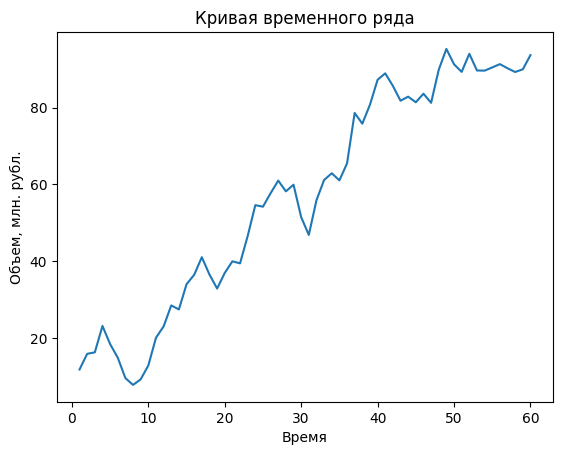

In [ ]:
import matplotlib.pyplot as plt

plt.plot(data['time'],data['volume'])
plt.xlabel("Время")
plt.ylabel("Объем, млн. рубл.")
plt.title("Кривая временного ряда")
plt.show()

Сезонность проявляется в виде повторяющихся колебаний или циклов в данных временного ряда. На графике можно заметить некоторые повторяющиеся пики и спады, которые могут указывать на наличие сезонной компоненты. Можно заметить, что объем увеличивается примерно каждые 6-12 месяцев, что может свидетельствовать о годовой сезонности.
Также на графике можно заметить возрастающий тренд.

RBF - полносвязная модель, состоящая из трех слоев: входного, одного скрытого и выходного. На скрытом слое в качестве функции активации используется радиально базисная функция, на остальных используются любые стандартные функции активации.

Для обучения модели неронной сети производится нормализация значений целевой переменной (объемов) при помощи MinMaxScaler.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data['volume_normalized'] = scaler.fit_transform(data[['volume']])

Для обучения модели данные также необходимо разделить. Признаки - год, месяц и время. Целевая переменная - объем. 80% - обучающие данные, 20% - тестовые.

In [ ]:
X = data[['year', 'month', 'time']]
X_train = X.head(48)
X_test = X.tail(12)
y = data['volume_normalized']
y_train = y.head(48)
y_test = y.tail(12)

Производится создание модели. Для создания указанной модели нейронной сети требуется радиально-базисная функция, которую можно создать вручную. В качестве функции используется мультиквадратичная функция.

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import backend as K

# Создание кастомной функции активации
def custom_activation(hidden_layer):
    r = hidden_layer
    K.set_epsilon(1)
    return K.sqrt(1 + (r*K.epsilon())*(r*K.epsilon()))

# Определение размерности входных данных
input_dim = 3

# Входной слой
input_layer = Input(shape=(input_dim,))

# Скрытый слой
hidden_layer = Dense(10, activation=custom_activation)(input_layer) # с указанием входного

# Выходной слой
output_layer = Dense(1)(hidden_layer)

# Создание модели
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_36 (Dense)            (None, 10)                40        
                                                                 
 dense_37 (Dense)            (None, 1)                 11        
                                                                 
Total params: 51 (204.00 Byte)
Trainable params: 51 (204.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Производится обучение модели на данных тренировочной выборки из первых четырех лет временного ряда.

In [ ]:
history = model.fit(X_train, y_train, epochs=150, batch_size=1, validation_data=(X_test, y_test))

Epoch 1/150
48/48 [==============================] - 1s 5ms/step - loss: 224487.3594 - val_loss: 23249.0879
Epoch 2/150
48/48 [==============================] - 0s 2ms/step - loss: 3787.2751 - val_loss: 24.1672
Epoch 3/150
48/48 [==============================] - 0s 3ms/step - loss: 23.0944 - val_loss: 7.5716
Epoch 4/150
48/48 [==============================] - 0s 3ms/step - loss: 4.7332 - val_loss: 7.6305
Epoch 5/150
48/48 [==============================] - 0s 3ms/step - loss: 4.6762 - val_loss: 8.2373
Epoch 6/150
48/48 [==============================] - 0s 3ms/step - loss: 4.5380 - val_loss: 7.4610
Epoch 7/150
48/48 [==============================] - 0s 2ms/step - loss: 4.5364 - val_loss: 7.4690
Epoch 8/150
48/48 [==============================] - 0s 3ms/step - loss: 4.5434 - val_loss: 7.0814
Epoch 9/150
48/48 [==============================] - 0s 3ms/step - loss: 4.5259 - val_loss: 6.4316
Epoch 10/150
48/48 [==============================] - 0s 2ms/step - loss: 4.7149 - val_loss: 8.

Строится график ошибок при обучении для анализа качества созданной модели.

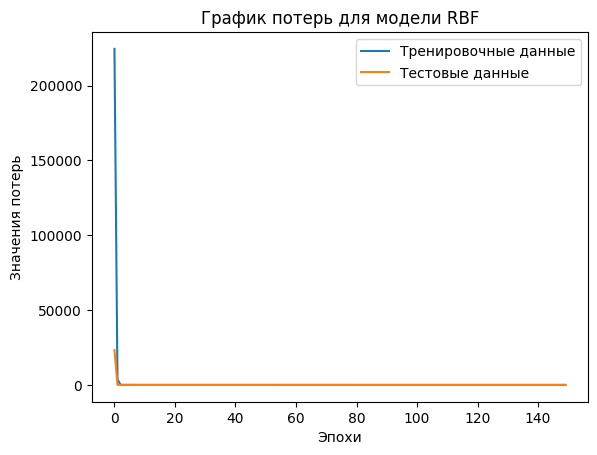

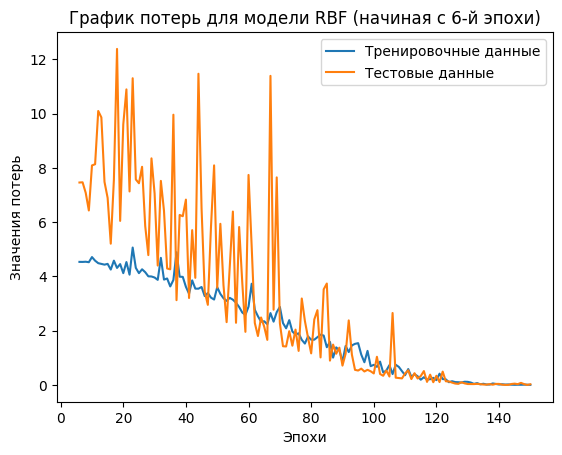

In [ ]:
import numpy as np

plt.plot(history.history['loss'], label='Тренировочные данные')
plt.plot(history.history['val_loss'], label='Тестовые данные')
plt.title('График потерь для модели RBF')
plt.xlabel('Эпохи')
plt.ylabel('Значения потерь')
plt.legend()
plt.show()

loss_values = history.history['loss'][5:]
val_loss_values = history.history['val_loss'][5:]
epochs = range(6, len(loss_values)+6)

plt.plot(epochs, loss_values, label='Тренировочные данные')
plt.plot(epochs, val_loss_values, label='Тестовые данные')
plt.title('График потерь для модели RBF (начиная с 6-й эпохи)')
plt.xlabel('Эпохи')
plt.ylabel('Значения потерь')
plt.legend()
plt.show()

Второй график, который начинается с 6 эпохи позволяет уточнить характер линии на данных в более крупном масштабе. На графике по всем эпохам из-за слишком высоких значений в самом начале не удается узнать характер распределения потерь для более поздних эпох.

На втором графике видно, что ближе к примерно 130 эпохе значения потерь уменьшаются и стабилизируются. Скорее всего переобучение модели еще не достигнуто.

Производится краткосрочное предсказание на 1 месяц вперед на основе данных последнего месяца из обучающей выборки.

In [ ]:
import numpy as np

# получение последней строки датафрейма
last_row = X_train.iloc[-1]

# получение данных для предсказаний
last_year = last_row['year']
last_month = last_row['month']
last_time = last_row['time']

# создание массива с данными последнего месяца для выполнения предсказаний
last_data = np.array([[last_year, last_month, last_time]])

# выполнение предсказания на месяц
next_month_prediction = model.predict(last_data)

print(f'Краткосрочный прогноз (на один месяц вперед): {next_month_prediction[0][0]}')
print(f'Реальное значение: {y_test.values[0]}')

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Расчет среднеквадратичной ошибки (MSE)
mse = mean_squared_error([y_test.values[0]], next_month_prediction[0])

# Расчет средней абсолютной ошибки (MAE)
mae = mean_absolute_error([y_test.values[0]], next_month_prediction[0])

print("Среднеквадратичная ошибка (MSE):", mse)
print("Средняя абсолютная ошибка (MAE):", mae)


1/1 [==============================] - 0s 61ms/step
Краткосрочный прогноз (на один месяц вперед): 0.953742265701294
Реальное значение: 1.0
Среднеквадратичная ошибка (MSE): 0.0021397779824496865
Средняя абсолютная ошибка (MAE): 0.046257734298706055


Спрогнозированное значение близко к реальному. Значение ошибок достаточно низкое, что говорит о хорошем качестве прогнозирования.

Производится среднесрочное предсказание на полгода вперед на основе данных последнего полугода из обучающей выборки.

In [ ]:
last_six_months_data = X_train.tail(6)

X_last_six_month_data = last_six_months_data[['year', 'month', 'time']]

next_six_month_prediction = model.predict(X_last_six_month_data)

print(f'Среднесрочный прогноз (на полгода вперед): {next_six_month_prediction.flatten()}')
print(f'Реальные значения: {y_test.head(6).values}')

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Расчет среднеквадратичной ошибки (MSE)
mse = mean_squared_error(y_test.head(6).values, next_six_month_prediction.flatten())

# Расчет средней абсолютной ошибки (MAE)
mae = mean_absolute_error(y_test.head(6).values, next_six_month_prediction.flatten())

print("Среднеквадратичная ошибка (MSE):", mse)
print("Средняя абсолютная ошибка (MAE):", mae)

1/1 [==============================] - 0s 20ms/step
Среднесрочный прогноз (на полгода вперед): [0.8638375  0.88202596 0.89990926 0.9177315  0.9356148  0.95374227]
Реальные значения: [1.         0.95418714 0.93168057 0.98549069 0.93590769 0.93533646]
Среднеквадратичная ошибка (MSE): 0.004947841262320944
Средняя абсолютная ошибка (MAE): 0.054425474413324015


Спрогнозированные значения близки к реальным. Значение ошибок достаточно низкое, что говорит о хорошем качестве прогнозирования. Однако оно выше, чем при краткосрочном прогнозировании.

Производится долгосрочное предсказание на год вперед на основе данных последнего года из обучающей выборки.

In [ ]:
months_data = X_train.tail(12)

X_month_data = months_data[['year', 'month', 'time']]

year_prediction = model.predict(X_month_data)

print(f'Долгосрочный прогноз (на год вперед): {year_prediction.flatten()}')
print(f'Реальные значения: {y_test.values}')

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Расчет среднеквадратичной ошибки (MSE)
mse = mean_squared_error(y_test.values, year_prediction.flatten())

# Расчет средней абсолютной ошибки (MAE)
mae = mean_absolute_error(y_test.values, year_prediction.flatten())

print("Среднеквадратичная ошибка (MSE):", mse)
print("Средняя абсолютная ошибка (MAE):", mae)

1/1 [==============================] - 0s 23ms/step
Долгосрочный прогноз (на год вперед): [0.75629354 0.7742989  0.79224324 0.8102486  0.82819295 0.84589314
 0.86377645 0.88202596 0.8999703  0.91779256 0.9356148  0.95374227]
Реальные значения: [1.         0.95418714 0.93168057 0.98549069 0.93590769 0.93533646
 0.94493317 0.95475837 0.94241974 0.93133783 0.93933509 0.98149206]
Среднеквадратичная ошибка (MSE): 0.014679456498850746
Средняя абсолютная ошибка (MAE): 0.0980655040938536


Качество спрогнозированных данных хорошее. Значения ошибок больше чем при предыдущих прогнозах, но незначительно.

Строится график реальных и предсказанных значений на основе построения нового предсказания для всех записей из исходного датафрейма.

2/2 [==============================] - 0s 5ms/step


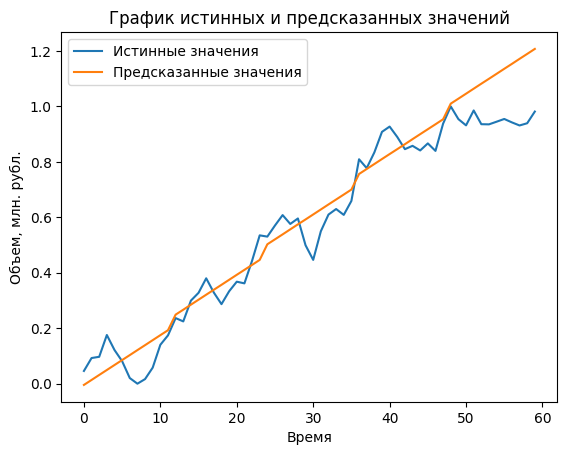

In [ ]:
X_data = data[['year', 'month', 'time']]
full_prediction = model.predict(X_data)

plt.plot(data['volume_normalized'], label='Истинные значения')
plt.plot(full_prediction.flatten(), label='Предсказанные значения')
plt.title('График истинных и предсказанных значений')
plt.xlabel("Время")
plt.ylabel("Объем, млн. рубл.")
plt.legend()
plt.show()

На основе графика истинных и предсказанных значений можно заметить, что модель не совсем хорошо описывает данных. Предсказанные значения периодически приближаются и отдаляются от истинных. Но также видно общую тенденцию реальных и предсказанных значений к увеличению.

Строится гистограмма остатков.

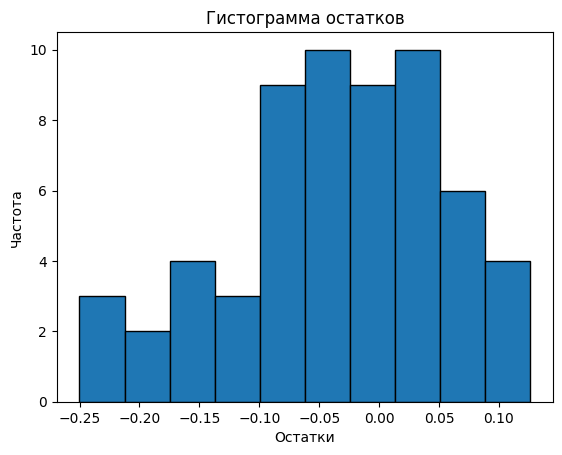

In [ ]:
ost = data['volume_normalized'].values - full_prediction.flatten()

# Построение гистограммы остатков
plt.hist(ost, bins=10, edgecolor='black')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.title('Гистограмма остатков')
plt.show()

На основе гистограммы остатков можно заметить, что большинство прогнозов находятся в большой близости к реальным значениям. А основном отклонения небольшие. Также можно заметить перимущественно отклонения в занижении прогнозов. Максимальным отклонением можно считать в данном случае 0.25.

**Вывод:**

В работе был проанализирован временной ряд объема производства промышленного предприятия по месяцам. Также была создана сеть радиально-базисных функций, при помощи которой были созданы прогнозы различной срочности.

На основе полученных данных ошибок из результатов предсказаний было выявлено, что модель примерно одинаково хорошо предсказывает данные на всех сроках прогнозирования.

Также при сравнении предсказаний на весь период было выявлено отклонение предсказаний от реальных значений в 0.25.

**Дополнительно:**

Создание нейронной сети с идентичной архитектурой, но с другой метрикой в компилляции.

In [ ]:
# Создание кастомной функции активации
def custom_activation(hidden_layer):
    r = hidden_layer
    K.set_epsilon(1)
    return K.sqrt(1 + (r*K.epsilon())*(r*K.epsilon()))

# Определение размерности входных данных
input_dim = 3

# Входной слой
input_layer = Input(shape=(input_dim,))

# Скрытый слой
hidden_layer = Dense(10, activation=custom_activation)(input_layer) # с указанием входного

# Выходной слой
output_layer = Dense(1)(hidden_layer)

# Создание модели
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='mean_absolute_error')

In [ ]:
history = model.fit(X_train, y_train, epochs=150, batch_size=1, validation_data=(X_test, y_test))

Epoch 1/150
48/48 [==============================] - 1s 5ms/step - loss: 132.5520 - val_loss: 24.7815
Epoch 2/150
48/48 [==============================] - 0s 3ms/step - loss: 11.6555 - val_loss: 30.5351
Epoch 3/150
48/48 [==============================] - 0s 2ms/step - loss: 9.8121 - val_loss: 20.7416
Epoch 4/150
48/48 [==============================] - 0s 2ms/step - loss: 10.0546 - val_loss: 23.3309
Epoch 5/150
48/48 [==============================] - 0s 3ms/step - loss: 9.3130 - val_loss: 29.5398
Epoch 6/150
48/48 [==============================] - 0s 3ms/step - loss: 8.8734 - val_loss: 20.4955
Epoch 7/150
48/48 [==============================] - 0s 3ms/step - loss: 7.1683 - val_loss: 31.6218
Epoch 8/150
48/48 [==============================] - 0s 3ms/step - loss: 10.3069 - val_loss: 6.3542
Epoch 9/150
48/48 [==============================] - 0s 2ms/step - loss: 9.2911 - val_loss: 21.7332
Epoch 10/150
48/48 [==============================] - 0s 3ms/step - loss: 6.8215 - val_loss: 11.

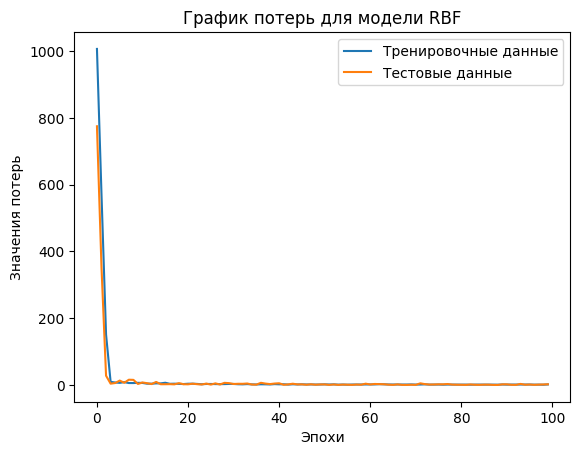

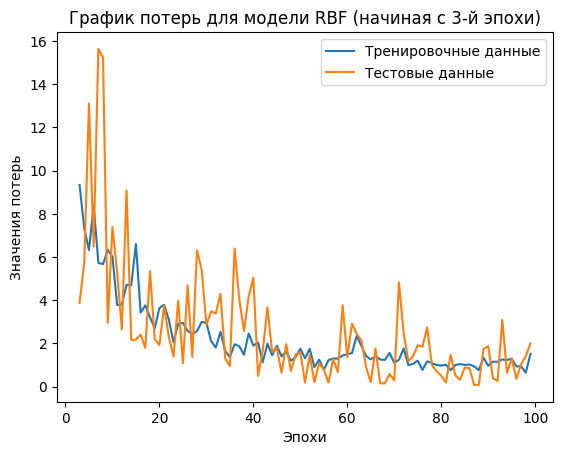

In [ ]:
plt.plot(history.history['loss'], label='Тренировочные данные')
plt.plot(history.history['val_loss'], label='Тестовые данные')
plt.title('График потерь для модели RBF')
plt.xlabel('Эпохи')
plt.ylabel('Значения потерь')
plt.legend()
plt.show()

loss_values = history.history['loss'][3:]
val_loss_values = history.history['val_loss'][3:]
epochs = range(3, len(loss_values)+3)

plt.plot(epochs, loss_values, label='Тренировочные данные')
plt.plot(epochs, val_loss_values, label='Тестовые данные')
plt.title('График потерь для модели RBF (начиная с 3-й эпохи)')
plt.xlabel('Эпохи')
plt.ylabel('Значения потерь')
plt.legend()
plt.show()

По графику обучения видно нестабильность значений на тестовой выборке. Первый минимум достигается примерно на 61 эпохе. Возможно следовало остановить обучение раньше.

2/2 [==============================] - 0s 5ms/step


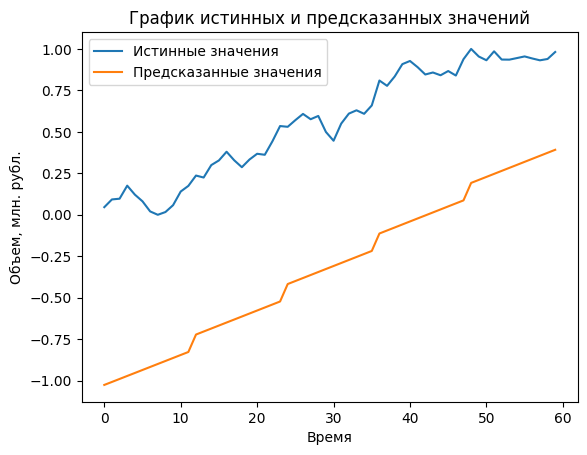

In [ ]:
X_data = data[['year', 'month', 'time']]
full_prediction = model.predict(X_data)

plt.plot(data['volume_normalized'], label='Истинные значения')
plt.plot(full_prediction.flatten(), label='Предсказанные значения')
plt.title('График истинных и предсказанных значений')
plt.xlabel("Время")
plt.ylabel("Объем, млн. рубл.")
plt.legend()
plt.show()

Предсказанные значения далеки от истинных. Модель плохо прогнозирет данные.

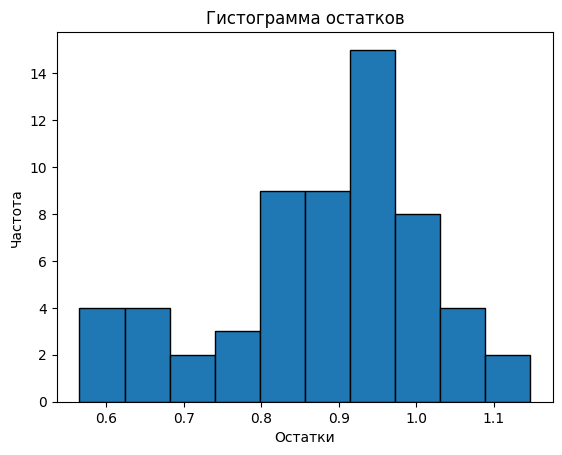

In [ ]:
ost = data['volume_normalized'].values - full_prediction.flatten()

# Построение гистограммы остатков
plt.hist(ost, bins=10, edgecolor='black')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.title('Гистограмма остатков')
plt.show()

По графику остатков видно, что модель прогнозирует значения ниже реальных в основном примерно на 1.1.

В результате сравнения двух нейронных сетей идетничной архитектуры с разными метриками обновления весов можно заметить, что для mae не требуется такого большого периода обучения, а также качество модели сильно хуже нежели с mse. Следовательно, для задачи прогнозирования на данном временном ряде лучше использоватеь модель с mse.